# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
#find number of samples per class for dog images 
import os
import re
import pandas as pd
classes=[]
for i in range(len(dog_files)):
    pth = os.path.dirname(dog_files[i])
    fold= os.path.basename(pth)
    s= re.sub('[^a-zA-Z]+', '', fold)
    classes.append(s)
df = pd.DataFrame(classes)
df.columns=["dog breed"]
df["dog breed"].value_counts().values

array([96, 93, 92, 89, 87, 86, 86, 84, 83, 83, 82, 82, 82, 81, 81, 81, 80,
       80, 80, 80, 80, 80, 80, 79, 79, 79, 79, 78, 78, 78, 77, 77, 76, 76,
       75, 74, 74, 73, 73, 72, 71, 71, 71, 70, 70, 68, 67, 67, 66, 66, 66,
       66, 66, 66, 66, 66, 65, 65, 64, 64, 63, 63, 63, 63, 63, 62, 62, 62,
       62, 62, 62, 62, 62, 61, 61, 60, 60, 60, 60, 60, 59, 59, 59, 59, 58,
       58, 58, 57, 57, 56, 56, 55, 55, 55, 55, 55, 55, 54, 54, 53, 53, 53,
       52, 51, 51, 51, 50, 49, 49, 49, 46, 46, 44, 44, 44, 42, 42, 42, 42,
       41, 41, 40, 39, 39, 38, 38, 38, 37, 37, 36, 35, 33, 33])

In [3]:
#some statistics on dog images height and width pixels
import cv2
h=[]
w=[]
for i in range(len(dog_files)):
    img1 = cv2.imread(dog_files[i])
    h.append(img1.shape[0])
    w.append(img1.shape[1])

a= np.array([h,w])
df = pd.DataFrame(data=np.transpose(a),columns = ["dog image height","dog image width"])
df.describe()

dog image height  dog image width
count       8351.000000      8351.000000
mean         529.044905       567.032571
std          333.197594       389.006647
min          113.000000       105.000000
25%          360.000000       375.000000
50%          467.000000       500.000000
75%          600.000000       640.000000
max         4003.000000      4278.000000

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


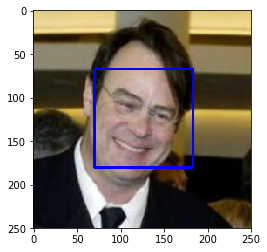

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  98%
- What percentage of the first 100 images in `dog_files` have a detected human face? 17%

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
s_human=0
for pic in human_files_short:
    if face_detector(pic):
        s_human = s_human+1
print("number of humans detected in human files: ",s_human)

s_dog=0
for pic in dog_files_short:
    if face_detector(pic):
        s_dog = s_dog+1
print("number of humans detected in dog files: ",s_dog)

number of humans detected in human files:  98
number of humans detected in dog files:  17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    #torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = torch.device("cuda" if use_cuda else "cpu")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:16<00:00, 33535411.48it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [54]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
   
    
    input_image = Image.open(img_path)
    
    transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    with torch.no_grad():
        output = VGG16(input_batch.to(device))
    return torch.max(output[0],0)[1].item() # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    if (151<= VGG16_predict(img_path) <=268):
        return True 
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 0 and 100% 


In [57]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
s_human=0
for pic in human_files_short:
    if dog_detector(pic):
        s_human = s_human+1
print("number of dogs detected in human files: ",s_human)

s_dog=0
for pic in dog_files_short:
    if dog_detector(pic):
        s_dog = s_dog+1
print("number of dogs detected in dog files: ",s_dog)

number of dogs detected in human files:  0
number of dogs detected in dog files:  100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [13]:
# construct train/valid/test files
train_files = np.array(glob("/data/dog_images/train/*/*"))
valid_files = np.array(glob("/data/dog_images/valid/*/*"))
test_files = np.array(glob("/data/dog_images/test/*/*"))
len(train_files),len(valid_files),len(test_files)

(6680, 835, 836)

In [15]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.RandomRotation(10),
     transforms.RandomAffine(5,scale=(0.9,1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

valid_test_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(root="/data/dog_images/train", transform=train_transform)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, num_workers = 0)
valid_data = datasets.ImageFolder(root="/data/dog_images/valid", transform=valid_test_transform)
valid_data_loader = torch.utils.data.DataLoader(valid_data, batch_size=20, shuffle=True, num_workers = 0)
test_data = datasets.ImageFolder(root="/data/dog_images/test", transform=valid_test_transform)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True, num_workers = 0)


loaders_scratch = {'train':train_data_loader,'valid':valid_data_loader,'test':test_data_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: For the purpose of model train/test, the 8351 dog images are split into 3 groups: 80% train data, 10% validation data and 10% test data. 
For CNN models, the selected input tensor size is (224,224,3). This means all the dog images are resized to 224by224 pixels. we see that the dog images has a wide range of pixels (heigh × width), with an average of 529×567. On the other hand selecting a larger tensor would incur expensive computation or memory problem. I found 224 a conventional input tensor size for similar image analysis problems. Also the input tensor is normalized to prevent the so called vanishing (and exploding) gradients.
Other transforms used (on train data only) are random 10 degree rotation and random scaling (0.9-1.1), this is because similar breeds on different pictures can have different scales due to closeness to camera or camera zoom. Also 10-degree rotation is to cover random dog position in the picture. 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 28 * 28 -> 200)
        self.fc1 = nn.Linear(64 * 28 * 28, 200)
        # linear layer (200 -> 200)
        self.fc2 = nn.Linear(200, 200)
        # linear layer (200 -> 133)
        self.fc3 = nn.Linear(200, 133)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        return x
    
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=133, bias=True)
  (dropout): Dropout(p=0.5)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ I tried some structure close to the one in the course content and tweaked it as needed: it consists of 3 convolutional layers with 16,32,64 filter depth. The kernel size is always 3, with a stride and padding of 1. Maxpool filter with kernel size of 2 is applied at the end of each convolution layer. After that there would be 3 fully connected layers with hidden nodes of 200 in each layer. The input layer to fc1 has a size of (224/8 × 224/8 × 64). The dropout function is applied at the end of fc1 and fc2 layers to prevent overfitting.   

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [30]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [31]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [27]:
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.889373 	Validation Loss: 4.885615
Validation loss decreased (inf --> 4.885615).  Saving model ...
Epoch: 2 	Training Loss: 4.884492 	Validation Loss: 4.881402
Validation loss decreased (4.885615 --> 4.881402).  Saving model ...
Epoch: 3 	Training Loss: 4.881107 	Validation Loss: 4.875140
Validation loss decreased (4.881402 --> 4.875140).  Saving model ...
Epoch: 4 	Training Loss: 4.875717 	Validation Loss: 4.865320
Validation loss decreased (4.875140 --> 4.865320).  Saving model ...
Epoch: 5 	Training Loss: 4.861743 	Validation Loss: 4.839222
Validation loss decreased (4.865320 --> 4.839222).  Saving model ...
Epoch: 6 	Training Loss: 4.825570 	Validation Loss: 4.778382
Validation loss decreased (4.839222 --> 4.778382).  Saving model ...
Epoch: 7 	Training Loss: 4.767542 	Validation Loss: 4.705001
Validation loss decreased (4.778382 --> 4.705001).  Saving model ...
Epoch: 8 	Training Loss: 4.720186 	Validation Loss: 4.675770
Validation loss decreased (4.70500

Epoch: 78 	Training Loss: 2.993073 	Validation Loss: 3.853657
Epoch: 79 	Training Loss: 2.964307 	Validation Loss: 3.850929
Epoch: 80 	Training Loss: 2.957022 	Validation Loss: 3.796119
Epoch: 81 	Training Loss: 2.915399 	Validation Loss: 3.848747
Epoch: 82 	Training Loss: 2.942201 	Validation Loss: 3.902599
Epoch: 83 	Training Loss: 2.827624 	Validation Loss: 3.844505
Epoch: 84 	Training Loss: 2.830211 	Validation Loss: 3.852635
Epoch: 85 	Training Loss: 2.809797 	Validation Loss: 3.844918
Epoch: 86 	Training Loss: 2.749820 	Validation Loss: 3.836204
Epoch: 87 	Training Loss: 2.760842 	Validation Loss: 3.828733
Epoch: 88 	Training Loss: 2.696267 	Validation Loss: 3.917313
Epoch: 89 	Training Loss: 2.679866 	Validation Loss: 3.844794
Epoch: 90 	Training Loss: 2.637328 	Validation Loss: 3.887511
Epoch: 91 	Training Loss: 2.602822 	Validation Loss: 3.837033
Epoch: 92 	Training Loss: 2.591113 	Validation Loss: 3.854650
Epoch: 93 	Training Loss: 2.553474 	Validation Loss: 3.871929
Epoch: 9

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [32]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.766495


Test Accuracy: 11% (96/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [33]:
## TODO: Specify data loaders
# using the previous data loaders
loaders_transfer = {'train':train_data_loader,'valid':valid_data_loader,'test':test_data_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [34]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
# print out the model structure
print(model_transfer)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [35]:
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
num_classes = 133
last_layer = nn.Linear(n_inputs, num_classes)

model_transfer.classifier[6] = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()
# print out the model structure after updating the last layer
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ VGG_16 is a well-known and pioneer architecture in image classification, that is why it is used here for transfer learning. In such learning transfer we will use the VGG16 model as is, except training the fc layers to have desired number of classes, so we freeze all the parameters of all convolution layers, and the training will be done only for 3 fc layers. As mentioned original VGG16 has 1000 output classes but our problem only needs 133 dog breed classes. 
The structure shown below, please note that the final fc layer has 133 outputs and not 1000.  




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [36]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:
# train the model
n_epochs = 10
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.160974 	Validation Loss: 2.934867
Validation loss decreased (inf --> 2.934867).  Saving model ...
Epoch: 2 	Training Loss: 2.372200 	Validation Loss: 1.436714
Validation loss decreased (2.934867 --> 1.436714).  Saving model ...
Epoch: 3 	Training Loss: 1.535879 	Validation Loss: 1.034782
Validation loss decreased (1.436714 --> 1.034782).  Saving model ...
Epoch: 4 	Training Loss: 1.225677 	Validation Loss: 0.878970
Validation loss decreased (1.034782 --> 0.878970).  Saving model ...
Epoch: 5 	Training Loss: 1.062067 	Validation Loss: 0.801729
Validation loss decreased (0.878970 --> 0.801729).  Saving model ...
Epoch: 6 	Training Loss: 0.962218 	Validation Loss: 0.743875
Validation loss decreased (0.801729 --> 0.743875).  Saving model ...
Epoch: 7 	Training Loss: 0.890259 	Validation Loss: 0.718677
Validation loss decreased (0.743875 --> 0.718677).  Saving model ...
Epoch: 8 	Training Loss: 0.830937 	Validation Loss: 0.693721
Validation loss decreased (0.71867

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [37]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.689769


Test Accuracy: 79% (666/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
   
    device = torch.device("cuda" if use_cuda else "cpu")
    
    input_image = Image.open(img_path)
    
    transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    output = model_transfer(input_batch.to(device))
    # convert output probabilities to predicted class
    pred = torch.max(output[0],0)[1].item()
    
    return class_names[pred]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [52]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import cv2
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    if dog_detector(img_path):
        print("Hello Dog! \n Your predicted breed is",predict_breed_transfer(img_path))
        
    elif face_detector(img_path):
        print("Hello Human! \n You look like a", predict_breed_transfer(img_path))

    else:
        print("error: input file contains no dog or human, please try again")

    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement) 
It worked fine as expected. points for improvement:
1- improve human face detector that shown 17% error
2- what if more than one dog is in a picture?: we need a new dog detector logic to find more than one dog in a picture
3- use more training dataset to improve the model accuracy
4- use other models for transfer learnings like AlexNet and compare the results

Hello Human! 
 You look like a Beagle


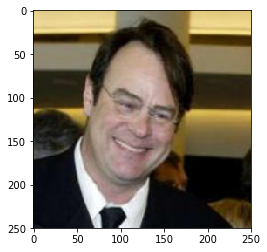

Hello Human! 
 You look like a Brittany


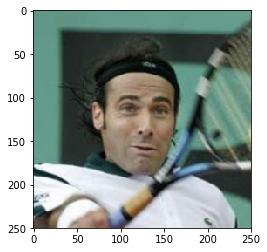

Hello Human! 
 You look like a Afghan hound


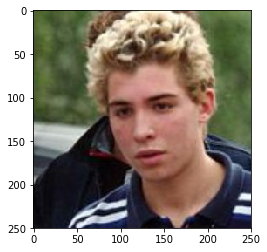

Hello Dog! 
 Your predicted breed is Doberman pinscher


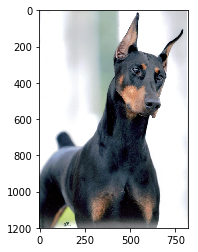

Hello Dog! 
 Your predicted breed is Borzoi


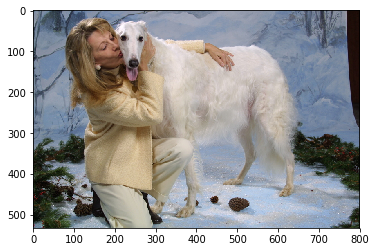

Hello Dog! 
 Your predicted breed is Chinese crested


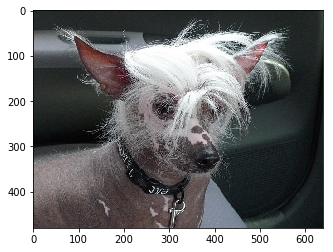

error: input file contains no dog or human, please try again


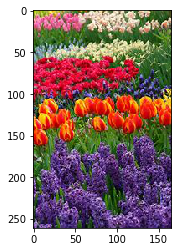

In [53]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
flower = "flower.jpg"
for file in np.hstack((human_files[:3], dog_files[[100,200,300]],flower)):
    run_app(file)

## BENCHMARK MODEL: multi-class logistic regression using SciKit Learn

In [1]:
import numpy as np
import cv2
from glob import glob
import os
import random
import re
from sklearn import preprocessing
from sklearn import metrics

train_dog_files = list(np.array(glob("/data/dog_images/train/*/*")))
random.shuffle(train_dog_files)

valid_dog_files = np.array(glob("/data/dog_images/valid/*/*"))
test_dog_files = np.array(glob("/data/dog_images/test/*/*"))


In [2]:
X_train = []
Y_train = []
for i in range(len(train_dog_files)):
    img = cv2.resize(cv2.imread(train_dog_files[i]),(224,224))
    X_train.append(img.flatten())
    pth = os.path.dirname(train_dog_files[i])
    s= os.path.basename(pth)
    Y_train.append(re.sub('[^a-zA-Z]+', '', s))

X_train = np.array(X_train)
X_train.shape

(6680, 150528)

In [3]:
X_test = []
Y_test = []
for i in range(len(test_dog_files)):
    img = cv2.resize(cv2.imread(test_dog_files[i]),(224,224))
    X_test.append(img.flatten())
    pth = os.path.dirname(test_dog_files[i])
    s= os.path.basename(pth)
    Y_test.append(re.sub('[^a-zA-Z]+', '', s))

X_test = np.array(X_test)
X_test.shape

(836, 150528)

In [4]:
from sklearn import preprocessing
Xtrain= preprocessing.StandardScaler().fit(X_train).transform(X_train)
Xtest= preprocessing.StandardScaler().fit(X_test).transform(X_test)


In [5]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1, solver='lbfgs',multi_class='multinomial',max_iter=10).fit(Xtrain,Y_train)


In [6]:
yPred_score = LR.predict(Xtest)
yPred_prob = LR.predict_proba(Xtest)

In [12]:
print("accuracy = {:.2f} %".format(sum(yPred_score==Y_test)/len(Y_test)*100))

accuracy = 4.78 %


In [14]:
print("log_loss = {:.2f}".format(metrics.log_loss(Y_test,yPred_prob)))

log_loss = 5.56
